In [1]:
# 授權绑定Google Drive
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 145655 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.14-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.14-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.14-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [2]:
# 取得雲端資料夾
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
# 列出資料夾底下的檔案列表
import os
os.chdir("/content/drive/My Drive/04 中興資管所/5 上課資料/電腦視覺與人機互動/final_project/final_project")
!ls

 glove.6B
 glove.6B.zip
 model_plot4a.png
 model_plot4b.png
'Multi-label Text Classification with Keras.ipynb'
'Multi-label Text Classification with Keras_Multiple Output Layers'
 Multi_label_Text_Classification_with_Keras_Multiple_Output_Layers.ipynb
 Multi_label_Text_Classification_with_Keras_Multiple_Output_Layers.pdf
 Multi_label_Text_Classification_with_Keras_Multiple_Output_Layers.py
'Multi-label Text Classification with Keras_Single Output Layers'
 Multi_label_Text_Classification_with_Keras_Single_Output_Layers.ipynb
 Multi_label_Text_Classification_with_Keras_Single_Output_Layers.pdf
 Multi_label_Text_Classification_with_Keras_Single_Output_Layers.py
 toxic-comment-classification
 toxic-comment-classification.zip
 toxic_comments.csv


In [4]:
# 匯入模組
import re
import pydot
import pandas as pd
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate
from google.colab import drive, files

Using TensorFlow backend.


In [5]:
# 將csv讀入colab的授權前置作業
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
drive

In [6]:
# 取得csv的共用連結'toxic_comments.csv'
link = 'https://drive.google.com/open?id=1w-NPyCW38I7CDVk4eDR6r6Cu6IL9UyfU' 
# The shareable link
fluff, id = link.split('=')
print('id =',id)

id = 1w-NPyCW38I7CDVk4eDR6r6Cu6IL9UyfU


In [7]:
# csv匯入dataframe
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('toxic_comments.csv')  
toxic_comments = pd.read_csv('toxic_comments.csv')
# 印出前5列
toxic_comments.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [8]:
# dataframe大小
toxic_comments.shape

(159571, 8)

In [9]:
# 刪除所有列包含空值或空字符串
filter = toxic_comments["comment_text"] != ""
toxic_comments = toxic_comments[filter]
toxic_comments = toxic_comments.dropna()
print('toxic_comments_filter Shape = ',toxic_comments.shape)

toxic_comments_filter Shape =  (159571, 8)


In [10]:
# 找其中一筆資料測試comment的詞語對應到的類別
print(toxic_comments["comment_text"][168])
print("Toxic:" + str(toxic_comments["toxic"][168]))
print("Severe_toxic:" + str(toxic_comments["severe_toxic"][168]))
print("Obscene:" + str(toxic_comments["obscene"][168]))
print("Threat:" + str(toxic_comments["threat"][168]))
print("Insult:" + str(toxic_comments["insult"][168]))
print("Identity_hate:" + str(toxic_comments["identity_hate"][168]))

You should be fired, you're a moronic wimp who is too lazy to do research. It makes me sick that people like you exist in this world.
Toxic:1
Severe_toxic:0
Obscene:0
Threat:0
Insult:1
Identity_hate:0


In [11]:
# 繪製每個標籤的評論數
toxic_comments_labels = toxic_comments[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]]
toxic_comments_labels.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0


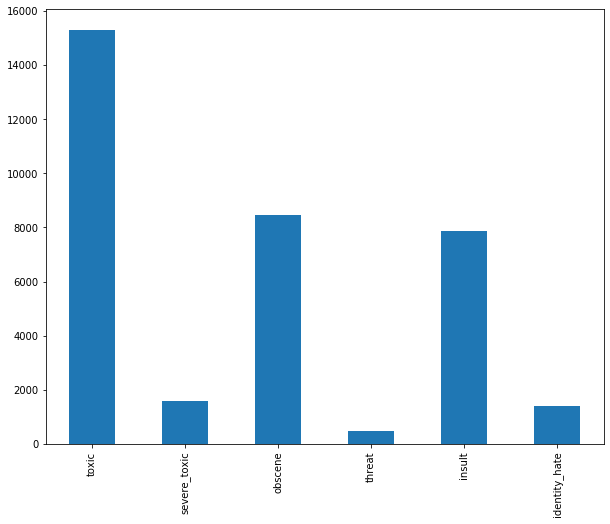

In [12]:
# 畫成長條圖
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

toxic_comments_labels.sum(axis=0).plot.bar()

**Multi-lable Text Classification Model with Single Output Layers**

In [0]:
# 文本分類模型的第一步是創建一個函式負責清理文本
def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [0]:
# 清理完的文本儲存在X
X = []
sentences = list(toxic_comments["comment_text"])
for sen in sentences:
    X.append(preprocess_text(sen))

y = toxic_comments_labels.values

In [0]:
# 分割訓練集和測試集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [16]:
# 將文本輸入轉換為嵌入向量
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1
print('vocab_size = ',vocab_size)

maxlen = 200

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

vocab_size =  148243


In [0]:
# 使用GloVe詞嵌入
embeddings_dictionary = dict()
glove_file = open('/content/drive/My Drive/04 中興資管所/5 上課資料/電腦視覺與人機互動/final_project/final_project/glove.6B/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [18]:
# 建立LSTM模型
deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(deep_inputs)
LSTM_Layer_1 = LSTM(128)(embedding_layer)
dense_layer_1 = Dense(6, activation='sigmoid')(LSTM_Layer_1)
model = Model(inputs=deep_inputs, outputs=dense_layer_1)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])












Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [19]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 200, 100)          14824300  
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 774       
Total params: 14,942,322
Trainable params: 118,022
Non-trainable params: 14,824,300
_________________________________________________________________


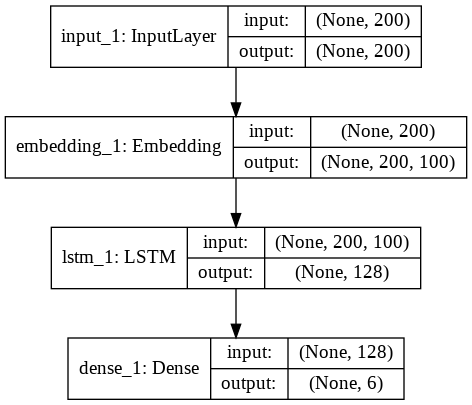

In [20]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

In [21]:
history = model.fit(X_train, y_train, batch_size=128, epochs=5, verbose=1, validation_split=0.2)



Train on 102124 samples, validate on 25532 samples
Epoch 1/5
102124/102124 [==============================] - 226s 2ms/step - loss: 0.1474 - acc: 0.9634 - val_loss: 0.1402 - val_acc: 0.9632
Epoch 2/5
102124/102124 [==============================] - 223s 2ms/step - loss: 0.1189 - acc: 0.9651 - val_loss: 0.0825 - val_acc: 0.9757
Epoch 3/5
102124/102124 [==============================] - 224s 2ms/step - loss: 0.0651 - acc: 0.9780 - val_loss: 0.0605 - val_acc: 0.9793
Epoch 4/5
102124/102124 [==============================] - 223s 2ms/step - loss: 0.0571 - acc: 0.9800 - val_loss: 0.0573 - val_acc: 0.9799
Epoch 5/5
102124/102124 [==============================] - 223s 2ms/step - loss: 0.0551 - acc: 0.9807 - val_loss: 0.0575 - val_acc: 0.9802


In [22]:
score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

31915/31915 [==============================] - 89s 3ms/step
Test Score: 0.05540275421135388
Test Accuracy: 0.9808031641333226


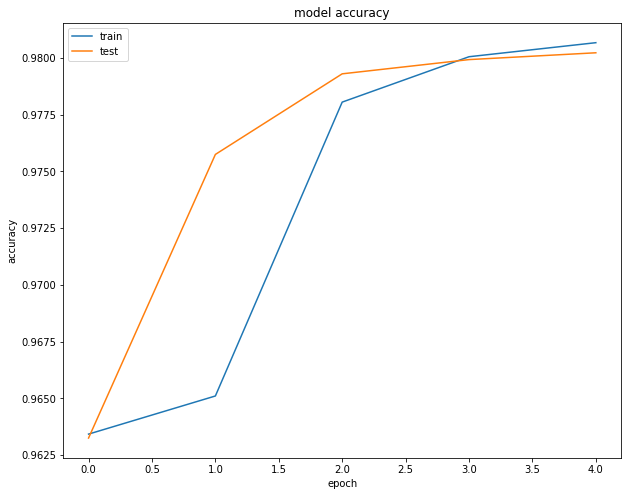

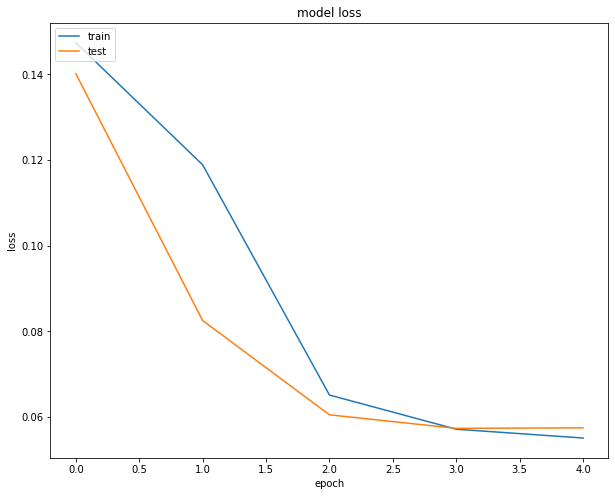

In [23]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()